# Предсказание показаний состояния пациента

### Данные
Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

### Переменные 
_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

### Задача
Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [68]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

In [69]:
df.iloc[:, 43:47]

трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   
        2                               0                              1   
        3                               0                              1   
GACAAnf 0                               0                              0   
...                                   ...                            ...   
GACBB;O 0                               0                              0   
        1                               0                              0   
GACXAAB 0                               0                              0   
        1                               0                              0   
        2                               0                              0   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  
case    t_point                                         
GACAAcY 0                         0                  0  
        1                         0                  0  
        2                         0                  0  
        3                         0                  0  
GACAAnf 0                         0                  0  
...                             ...                ...  
GACBB;O 0                         0                  0  
        1                         0                  0  
GACXAAB 0                         0                  0  
        1                         0                  0  
        2                         0                  0  

[6188 rows x 4 columns]

# Predict next period by last one

In [70]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

### Data preparation 

Our suggestion is to divide history by 3 periods

Count of patients: 1992


<AxesSubplot: >

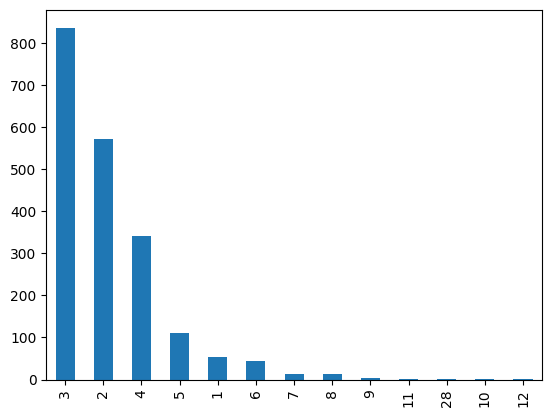

In [71]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

#### Scaling and imputing

Scale values as (x-min(x))/(max(x)-min(x))

Impute NaN values using MICE method with IterativeImputer on Linear regression as estimator 

Divide on train, test, validation splits

#### Function which shows results of model

In [72]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)

    r2_scor = r2_score(y_test, y_pred, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.append(mse_score)
    table.append(r2_scor)

    df_score = pd.DataFrame(table, ["MSE", "R2"], columns=df.columns[29:42])
    df_score.to_csv("reports_w1/"+model.name+".csv")
    model.save("models_w1/"+model.name)
    display(df_score)
    plt.show()
    

## Train Models

#### Here we will use window size 1

In [73]:
import prepare_data_covid as datacovid
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_dynamic(df_input=df, window=1)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[4:], y_train[4:]), (X_test[4:], y_test[4:]), (X_val[4:], y_val[4:])
X_train.shape

TRAIN shape:  (3356, 1, 13)
TEST shape:  (420, 13)
VAL shape:  (420, 13)


(3352, 1, 13)

#### FNN

Model: "Faltten2Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 13)                0         
                                                                 
 dense_49 (Dense)            (None, 13)                182       
                                                                 
 dense_50 (Dense)            (None, 13)                182       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 0s 2ms/step - loss: 0.1436 - val_loss: 0.0621
Epoch 2/30
105/105 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0259
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 4/30
105/105 

INFO:tensorflow:Assets written to: models_w1/Faltten2Layer\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002515,0.000402,0.001017,0.008475,0.000195,0.001632,0.008455,0.009772,0.012004,0.005080,0.069520,0.000771,0.005166
R2,-0.047552,0.021497,-3.548916,-0.002270,0.126297,0.254766,0.456608,0.236184,0.356584,0.898571,0.005621,0.121574,0.597463


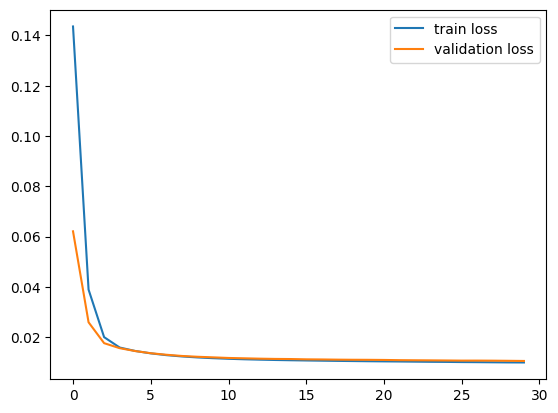

In [74]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW=X_train.shape[1]
model = Sequential(name="Faltten2Layer")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(PARAMS_LENGTH, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten3Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 13)                0         
                                                                 
 dense_51 (Dense)            (None, 13)                182       
                                                                 
 dense_52 (Dense)            (None, 32)                448       
                                                                 
 dense_53 (Dense)            (None, 13)                429       
                                                                 
Total params: 1,059
Trainable params: 1,059
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 1s 2ms/step - loss: 0.0664 - val_loss: 0.0174
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0141 -

INFO:tensorflow:Assets written to: models_w1/Flatten3Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002446,0.000145,0.000230,0.008448,0.000165,0.001319,0.005606,0.009292,0.010956,0.005097,0.067715,0.000798,0.004724
R2,-0.018610,0.646399,-0.028205,0.001001,0.260884,0.397709,0.639676,0.273760,0.412794,0.898233,0.031437,0.091414,0.631905


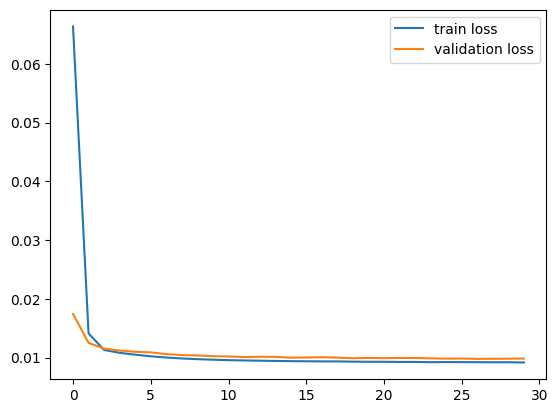

In [75]:
model = Sequential(name="Flatten3Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten4Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 13)                0         
                                                                 
 dense_54 (Dense)            (None, 13)                182       
                                                                 
 dense_55 (Dense)            (None, 32)                448       
                                                                 
 dense_56 (Dense)            (None, 32)                1056      
                                                                 
 dense_57 (Dense)            (None, 13)                429       
                                                                 
Total params: 2,115
Trainable params: 2,115
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================

INFO:tensorflow:Assets written to: models_w1/Flatten4Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002746,0.000176,0.000280,0.008711,0.000224,0.001491,0.005753,0.009761,0.011756,0.004900,0.067795,0.000880,0.004587
R2,-0.143513,0.571339,-0.252122,-0.030203,-0.000187,0.319314,0.630253,0.237107,0.369893,0.902174,0.030294,-0.002377,0.642589


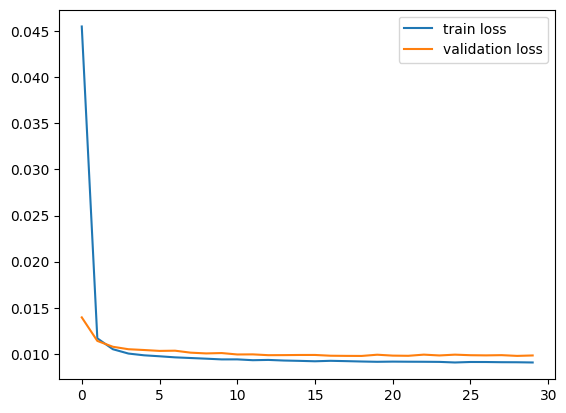

In [76]:
model = Sequential(name="Flatten4Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten5Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 13)                0         
                                                                 
 dense_58 (Dense)            (None, 13)                182       
                                                                 
 dense_59 (Dense)            (None, 32)                448       
                                                                 
 dense_60 (Dense)            (None, 32)                1056      
                                                                 
 dense_61 (Dense)            (None, 32)                1056      
                                                                 
 dense_62 (Dense)            (None, 13)                429       
                                                                 
Total params: 3,171
Trainable params: 3,171
Non-trai

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002888,0.000204,0.000170,0.008471,0.000161,0.001749,0.006047,0.009935,0.011093,0.005025,0.067288,0.000734,0.004843
R2,-0.202906,0.503006,0.239483,-0.001726,0.280307,0.201653,0.611379,0.223473,0.405434,0.899682,0.037550,0.163559,0.622669


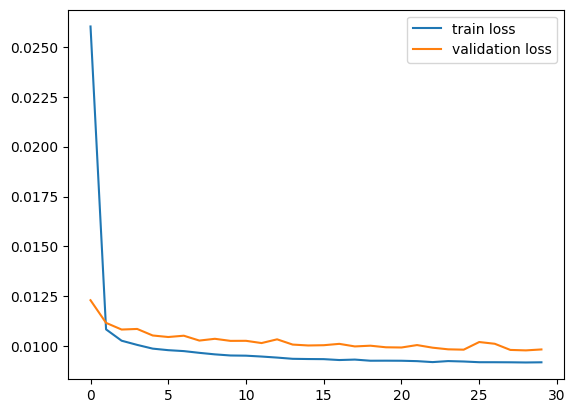

In [77]:
model = Sequential(name="Flatten5Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten3Layers_batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (8, 13)                   0         
                                                                 
 dense_63 (Dense)            (8, 13)                   182       
                                                                 
 dense_64 (Dense)            (8, 32)                   448       
                                                                 
 dense_65 (Dense)            (8, 13)                   429       
                                                                 
Total params: 1,059
Trainable params: 1,059
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
419/419 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0123
Epoch 2/30
419/419 [==============================] - 1s 1ms/step - loss: 0

INFO:tensorflow:Assets written to: models_w1/Flatten3Layers_batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002690,0.000245,0.000216,0.008367,0.000147,0.001348,0.005638,0.009045,0.010854,0.005269,0.069262,0.000791,0.005175
R2,-0.120533,0.404619,0.034927,0.010583,0.342372,0.384406,0.637670,0.293007,0.418218,0.894800,0.009306,0.099181,0.596753


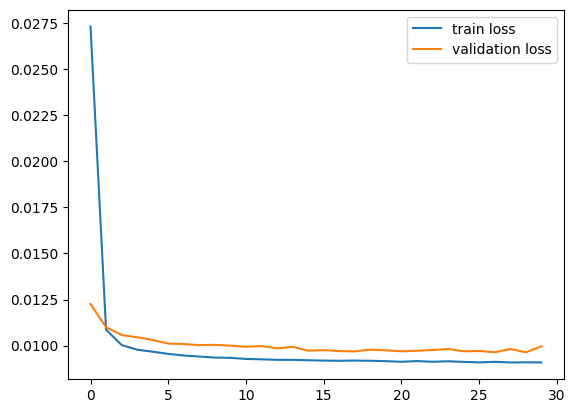

In [78]:
BATCH_SIZE=8
model = Sequential(name="Flatten3Layers_batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten3Layers_batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (4, 13)                   0         
                                                                 
 dense_66 (Dense)            (4, 13)                   182       
                                                                 
 dense_67 (Dense)            (4, 32)                   448       
                                                                 
 dense_68 (Dense)            (4, 13)                   429       
                                                                 
Total params: 1,059
Trainable params: 1,059
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
838/838 [==============================] - 2s 2ms/step - loss: 0.0208 - val_loss: 0.0112
Epoch 2/30
838/838 [==============================] - 1s 989us/step - loss:

INFO:tensorflow:Assets written to: models_w1/Flatten3Layers_batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002445,0.000212,0.000154,0.008560,0.000191,0.001398,0.005750,0.009134,0.011094,0.005542,0.067932,0.000792,0.005177
R2,-0.018152,0.483068,0.313549,-0.012326,0.144792,0.361937,0.630448,0.286082,0.405361,0.889357,0.028335,0.098203,0.596647


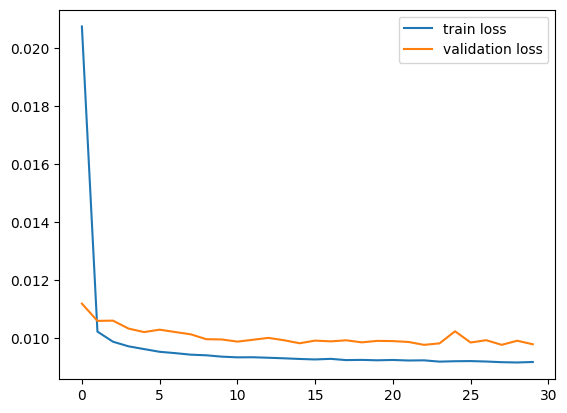

In [79]:
BATCH_SIZE=4
model = Sequential(name="Flatten3Layers_batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten3Layers_batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (2, 13)                   0         
                                                                 
 dense_69 (Dense)            (2, 13)                   182       
                                                                 
 dense_70 (Dense)            (2, 32)                   448       
                                                                 
 dense_71 (Dense)            (2, 13)                   429       
                                                                 
Total params: 1,059
Trainable params: 1,059
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0142 - val_loss: 0.0109
Epoch 2/30
1676/1676 [==============================] - 2s 1ms/step - los

INFO:tensorflow:Assets written to: models_w1/Flatten3Layers_batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002395,0.000142,0.000272,0.008662,0.000157,0.001397,0.005431,0.008988,0.012394,0.004798,0.070053,0.000807,0.004683
R2,0.002703,0.654899,-0.217651,-0.024305,0.299234,0.362046,0.650920,0.297529,0.335726,0.904208,-0.001999,0.081084,0.635137


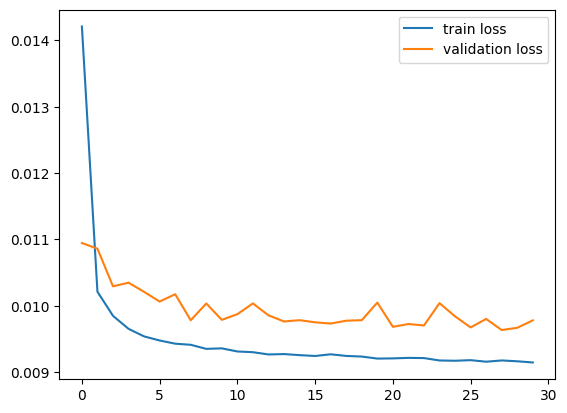

In [80]:
BATCH_SIZE=2
model = Sequential(name="Flatten3Layers_batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten5Layers_batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (8, 13)                   0         
                                                                 
 dense_72 (Dense)            (8, 13)                   182       
                                                                 
 dense_73 (Dense)            (8, 32)                   448       
                                                                 
 dense_74 (Dense)            (8, 32)                   1056      
                                                                 
 dense_75 (Dense)            (8, 32)                   1056      
                                                                 
 dense_76 (Dense)            (8, 13)                   429       
                                                                 
Total params: 3,171
Trainable params: 3,171
N

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002435,0.000140,0.000386,0.008779,0.000163,0.001407,0.005438,0.009496,0.011086,0.004877,0.067707,0.000963,0.004615
R2,-0.014324,0.658617,-0.725231,-0.038191,0.269338,0.357770,0.650498,0.257777,0.405795,0.902640,0.031554,-0.096597,0.640442


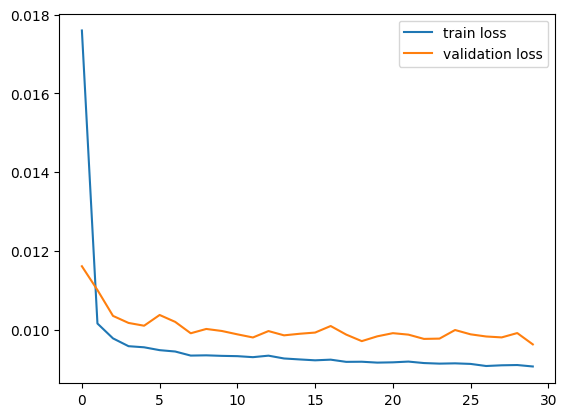

In [81]:
BATCH_SIZE=8
model = Sequential(name="Flatten5Layers_batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten5Layers_batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (2, 13)                   0         
                                                                 
 dense_77 (Dense)            (2, 13)                   182       
                                                                 
 dense_78 (Dense)            (2, 32)                   448       
                                                                 
 dense_79 (Dense)            (2, 32)                   1056      
                                                                 
 dense_80 (Dense)            (2, 32)                   1056      
                                                                 
 dense_81 (Dense)            (2, 13)                   429       
                                                                 
Total params: 3,171
Trainable params: 3,171
N

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002395,0.000217,0.000172,0.008848,0.000165,0.001512,0.005798,0.00918,0.011014,0.005420,0.070402,0.000805,0.005085
R2,0.002740,0.471926,0.229267,-0.046355,0.260942,0.309619,0.627331,0.28249,0.409684,0.891795,-0.006991,0.083765,0.603776


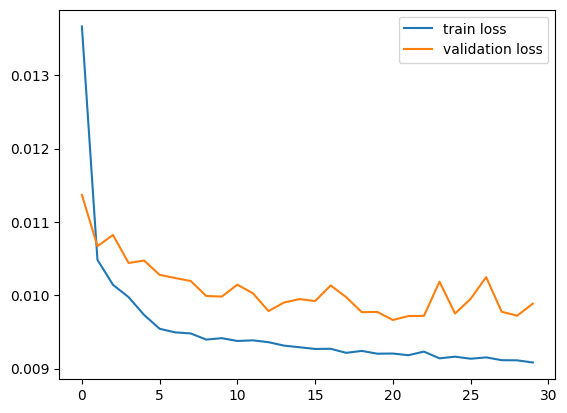

In [82]:
BATCH_SIZE=2
model = Sequential(name="Flatten5Layers_batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten5Layers_batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (4, 13)                   0         
                                                                 
 dense_82 (Dense)            (4, 13)                   182       
                                                                 
 dense_83 (Dense)            (4, 32)                   448       
                                                                 
 dense_84 (Dense)            (4, 32)                   1056      
                                                                 
 dense_85 (Dense)            (4, 32)                   1056      
                                                                 
 dense_86 (Dense)            (4, 13)                   429       
                                                                 
Total params: 3,171
Trainable params: 3,171
N

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002376,0.000197,0.000156,0.008463,0.000147,0.001528,0.005411,0.009508,0.010904,0.005024,0.068118,0.000753,0.005398
R2,0.010550,0.521054,0.300406,-0.000822,0.344241,0.302468,0.652261,0.256857,0.415583,0.899698,0.025679,0.142960,0.579390


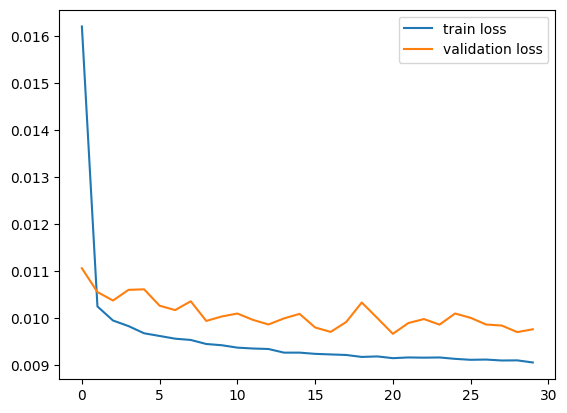

In [83]:
BATCH_SIZE=4
model = Sequential(name="Flatten5Layers_batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

## Train with static parameters


Lets define new function for splitting

In [84]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_data_with_static(df_input=df, window=1)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[4:], y_train[4:]), (X_test[4:], y_test[4:]), (X_val[4:], y_val[4:])
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_val.shape, y_val.shape)

(((3352, 1, 47), (3352, 13)),
 ((416, 1, 47), (416, 13)),
 ((416, 1, 47), (416, 13)))

#### FNN

Flatten3Layers_Mixed

Model: "Flatten2Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 47)                0         
                                                                 
 dense_87 (Dense)            (None, 47)                2256      
                                                                 
 dense_88 (Dense)            (None, 13)                624       
                                                                 
Total params: 2,880
Trainable params: 2,880
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0330
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 3/30
105/105 [==============================] - 0s 2ms/step - loss: 0.0167 - val_loss: 0.0180
Epoch 4/

INFO:tensorflow:Assets written to: models_w1/Flatten2Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001536,0.000321,0.000271,0.008422,0.000564,0.000974,0.006876,0.008242,0.010199,0.005924,0.069406,0.000711,0.005831
R2,-0.129344,-7.735878,-0.176490,-0.054341,-0.047593,0.034465,0.567352,0.268179,0.273611,0.895129,0.018438,-0.114441,0.551620


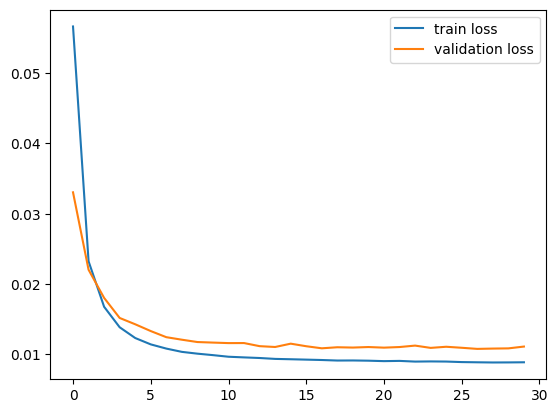

In [85]:
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten2Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten3Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 47)                0         
                                                                 
 dense_89 (Dense)            (None, 47)                2256      
                                                                 
 dense_90 (Dense)            (None, 64)                3072      
                                                                 
 dense_91 (Dense)            (None, 13)                845       
                                                                 
Total params: 6,173
Trainable params: 6,173
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 1s 3ms/step - loss: 0.0423 - val_loss: 0.0229
Epoch 2/30
105/105 [==============================] - 0s 2ms/step - loss: 0.

INFO:tensorflow:Assets written to: models_w1/Flatten3Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001416,0.000418,0.000445,0.008201,0.000492,0.001499,0.007102,0.008661,0.010354,0.005186,0.070800,0.000715,0.006567
R2,-0.041336,-10.366083,-0.933684,-0.026723,0.085911,-0.487080,0.553137,0.230948,0.262584,0.908189,-0.001277,-0.120662,0.494984


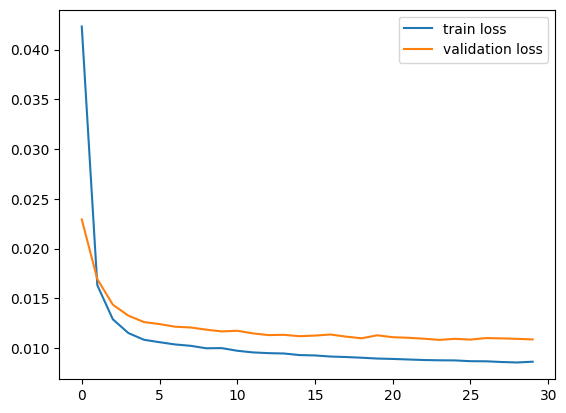

In [86]:
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten3Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(64, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten4Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 47)                0         
                                                                 
 dense_92 (Dense)            (None, 47)                2256      
                                                                 
 dense_93 (Dense)            (None, 32)                1536      
                                                                 
 dense_94 (Dense)            (None, 32)                1056      
                                                                 
 dense_95 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,277
Trainable params: 5,277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [========================

INFO:tensorflow:Assets written to: models_w1/Flatten4Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001719,0.000394,0.000240,0.008478,0.000506,0.001255,0.006726,0.008176,0.009887,0.005483,0.074314,0.000614,0.005799
R2,-0.264452,-9.723597,-0.040847,-0.061388,0.059635,-0.244850,0.576845,0.273990,0.295861,0.902933,-0.050962,0.036587,0.554049


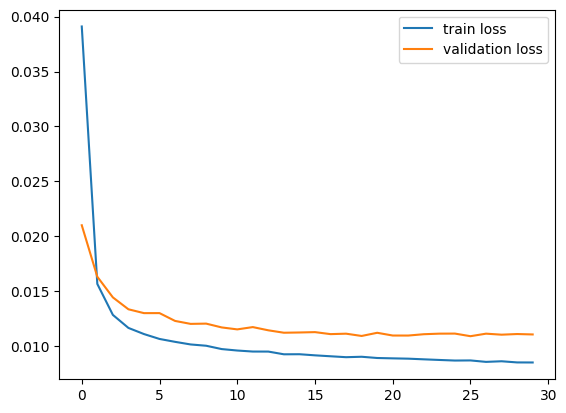

In [87]:
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten4Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten5Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 47)                0         
                                                                 
 dense_96 (Dense)            (None, 47)                2256      
                                                                 
 dense_97 (Dense)            (None, 32)                1536      
                                                                 
 dense_98 (Dense)            (None, 32)                1056      
                                                                 
 dense_99 (Dense)            (None, 32)                1056      
                                                                 
 dense_100 (Dense)           (None, 13)                429       
                                                                 
Total params: 6,333
Trainable params: 6,333
No

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001477,0.00046,0.000271,0.008202,0.000549,0.001340,0.006872,0.008591,0.009871,0.005259,0.073588,0.000762,0.005843
R2,-0.086514,-11.49204,-0.175756,-0.026816,-0.018913,-0.328581,0.567661,0.237220,0.296953,0.906894,-0.040700,-0.194183,0.550675


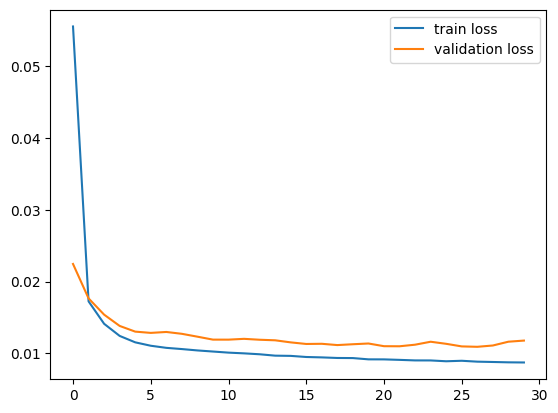

In [88]:
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten5Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten5Layers_Mixed_batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (8, 47)                   0         
                                                                 
 dense_101 (Dense)           (8, 47)                   2256      
                                                                 
 dense_102 (Dense)           (8, 32)                   1536      
                                                                 
 dense_103 (Dense)           (8, 32)                   1056      
                                                                 
 dense_104 (Dense)           (8, 32)                   1056      
                                                                 
 dense_105 (Dense)           (8, 13)                   429       
                                                                 
Total params: 6,333
Trainable params: 6

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_Mixed_batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001474,0.000349,0.000829,0.008153,0.000501,0.001658,0.006825,0.009899,0.011151,0.005267,0.072403,0.000781,0.005923
R2,-0.083660,-8.492134,-2.598458,-0.020657,0.069859,-0.644070,0.570618,0.121037,0.205798,0.906754,-0.023947,-0.224256,0.544510


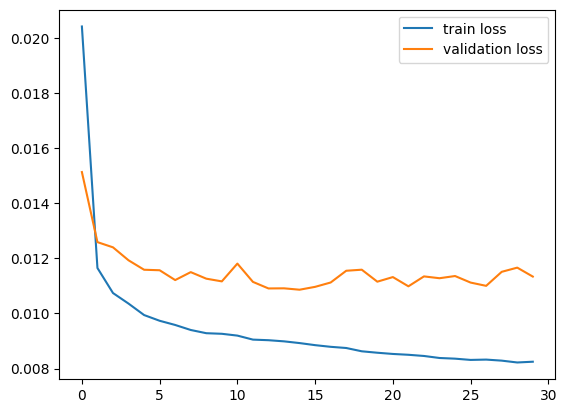

In [89]:
BATCH_SIZE = 8
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten5Layers_Mixed_batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten5Layers_Mixed_batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (4, 47)                   0         
                                                                 
 dense_106 (Dense)           (4, 47)                   2256      
                                                                 
 dense_107 (Dense)           (4, 32)                   1536      
                                                                 
 dense_108 (Dense)           (4, 32)                   1056      
                                                                 
 dense_109 (Dense)           (4, 32)                   1056      
                                                                 
 dense_110 (Dense)           (4, 13)                   429       
                                                                 
Total params: 6,333
Trainable params: 6

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_Mixed_batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001346,0.000173,0.000299,0.008135,0.000539,0.001107,0.007023,0.007853,0.011133,0.005053,0.072884,0.000715,0.005555
R2,0.010056,-3.715467,-0.299362,-0.018371,-0.000936,-0.098259,0.558108,0.302661,0.207112,0.910550,-0.030749,-0.120954,0.572805


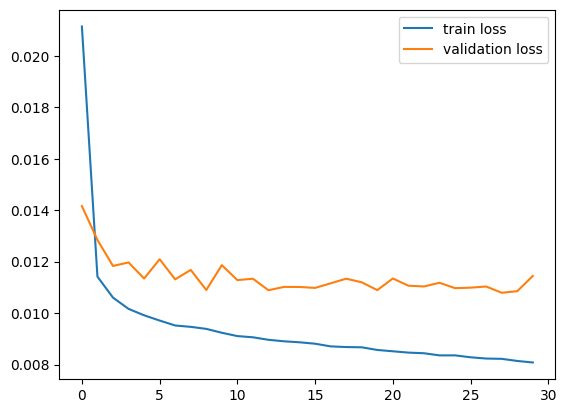

In [90]:
BATCH_SIZE = 4
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten5Layers_Mixed_batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "Flatten5Layers_Mixed_batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (2, 47)                   0         
                                                                 
 dense_111 (Dense)           (2, 47)                   2256      
                                                                 
 dense_112 (Dense)           (2, 32)                   1536      
                                                                 
 dense_113 (Dense)           (2, 32)                   1056      
                                                                 
 dense_114 (Dense)           (2, 32)                   1056      
                                                                 
 dense_115 (Dense)           (2, 13)                   429       
                                                                 
Total params: 6,333
Trainable params: 6

INFO:tensorflow:Assets written to: models_w1/Flatten5Layers_Mixed_batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001392,0.000134,0.000208,0.007973,0.000483,0.001131,0.006643,0.008191,0.011453,0.005086,0.077762,0.000611,0.005484
R2,-0.023993,-2.654103,0.095153,0.001912,0.103859,-0.121694,0.582034,0.272712,0.184329,0.909950,-0.099735,0.042229,0.578261


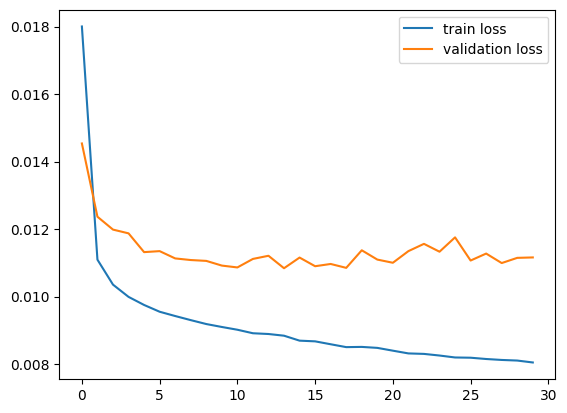

In [91]:
BATCH_SIZE = 2
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model = Sequential(name="Flatten5Layers_Mixed_batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(32, activation="linear"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)